# CAPSTONE PROJECT

#### THIS NOTEBOOK WILL BE MAINLY USED FOR THE CAPSTONE PROJECT FROM IBM DATA SCIENCE PROFESSIONAL CERTIFICATE

## 1. Import important libraries

In [3]:
#!pip install --upgrade requests branca six jinja2 numpy chardet idna urllib3 certifi MarkupSafe
#!conda install -c conda-forge folium --yes
#!conda install -c conda-forge geopy --yes
import numpy as np
import pandas as pd
import requests
from sklearn.cluster import KMeans
from pandas.io.json import json_normalize
import folium
from folium.plugins import MiniMap
from geopy.geocoders import Nominatim
import json
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn import metrics
print('Libraries imported.')

Libraries imported.


## 2. Load Neighborhoods in New York and Toronto from:
* New York: https://ibm.box.com/shared/static/fbpwbovar7lf8p5sgddm06cgipa2rxpe.json
* Toronto: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

### 2.1. Download and load New York data

In [4]:
!wget -q -O 'newyork_data.json' https://ibm.box.com/shared/static/fbpwbovar7lf8p5sgddm06cgipa2rxpe.json
print('Data downloaded!')
print('Loading data...')
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    
print('\n...data loaded succesfully!')

Data downloaded!
Loading data...

...data loaded succesfully!


#### 2.1.1. Let's take a look at the relevant data in a *pandas* dataframe

In [5]:
neighborhoods_ny = pd.DataFrame(columns = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'])
for data in newyork_data['features']:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods_ny = neighborhoods_ny.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

#Take only neighborhoods from manhattan!
neighborhoods_ny = neighborhoods_ny[neighborhoods_ny['Borough'] == 'Manhattan'].reset_index(drop=True)
neighborhoods_ny.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [6]:
print("{} neighborhoods found in New York city.".format(neighborhoods_ny.shape[0]))

40 neighborhoods found in New York city.


### 2.2. Download and load Toronto data

In [7]:
webPage = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
print('Data downloaded!')
print('Loading data...')
html = webPage.text                                                                       
tableInit = html.find('<table class="wikitable sortable">')                            
tableFinal = html.find('</table>')                                                      
htmlTable = html[tableInit:tableFinal]
print('\n...data loaded succesfully!')

Data downloaded!
Loading data...

...data loaded succesfully!


#### 2.2.1. Let's take a look at the relevant data in a *pandas* dataframe

In [8]:
table = pd.read_html(htmlTable, header = 0)[0]                                            
table["Borough"] = table["Borough"].replace({"Not assigned":np.nan})                
table.dropna(inplace = True)                                                          
table.where(table != "Not assigned", table["Borough"], axis = 0, inplace = True)      
joinedRows = table.groupby("Postcode")["Neighbourhood"].apply(lambda x: ", ".join(x)) 
table.drop_duplicates(["Postcode"],inplace = True)                                    
df = table.join(joinedRows, on = "Postcode", lsuffix='_single')                       
df.drop(columns = ["Neighbourhood_single"], inplace = True)                         
df.reset_index(drop = True, inplace = True)

Add latitude and longitude from: http://cocl.us/Geospatial_data

In [9]:
!wget -q -O 'Geospatial_Coordinates.csv' http://cocl.us/Geospatial_data
geo = pd.read_csv("Geospatial_Coordinates.csv", index_col = 0)         
neighborhoods_to = df.join(geo, on = "Postcode")

#Take only those neighborhoods that contain the word Toronto
neighborhoods_to = neighborhoods_to[neighborhoods_to['Borough'].str.contains('Toronto')].reset_index(drop=True)
neighborhoods_to.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636
1,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
3,M4E,East Toronto,The Beaches,43.676357,-79.293031
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306


In [10]:
print("\n{} neighborhoods found in the city of Toronto.".format(neighborhoods_to.shape[0]))


38 neighborhoods found in the city of Toronto.


### 2.3. Visualize the neighborhoods in New York and Toronto

#### 2.3.1. Get center coordinates to visualize both cities at the same time

In [11]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
ny_latitude = location.latitude
ny_longitude = location.longitude
print('The geograpical coordinate of New York City (Manhattan) are {}, {}.'.format(ny_latitude, ny_longitude))

address = 'Toronto'

location = geolocator.geocode(address)
to_latitude = location.latitude
to_longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(to_latitude, to_longitude))

centerLatitude = (ny_latitude + to_latitude)/2
centerLongitude = (ny_longitude + to_longitude)/2

print('\nThe geograpical central coordinates are {}, {}.'.format(centerLatitude, centerLongitude))

The geograpical coordinate of New York City (Manhattan) are 40.7900869, -73.9598295.
The geograpical coordinate of Toronto are 43.653963, -79.387207.

The geograpical central coordinates are 42.22202495, -76.67351825.


#### 2.3.2 Append New York and Toronto tables

In [12]:
tmp = neighborhoods_to.drop("Postcode",axis = 1)
tmp.rename(columns = {"Neighbourhood":"Neighborhood"}, inplace = True)
df = neighborhoods_ny.append(tmp, True).reset_index(drop = True)
pd.set_option('max_rows', 6)
df

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
...,...,...,...,...
75,Downtown Toronto,"First Canadian Place, Underground city",43.648429,-79.382280
76,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
77,East Toronto,Business reply mail Processing Centre969 Eastern,43.662744,-79.321558


#### 2.3.3 Visualize neighborhoods in a map using *Folium*

In [13]:
map_tony = folium.Map(location=[centerLatitude, centerLongitude], zoom_start=7, width='100%', height='100%')

for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_tony)
map_tony

NEW YORK CITY

In [14]:
map_tony = folium.Map(location=[ny_latitude, ny_longitude], zoom_start=11, width='100%', height='100%')

for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_tony)

minimap = MiniMap(position = 'topleft', center_fixed = (ny_latitude, ny_longitude), zoom_level_fixed = 8)
minimap.add_to(map_tony)

minimap = MiniMap(position='bottomright',  center_fixed = (to_latitude, to_longitude), zoom_level_fixed = 8)
minimap.add_to(map_tony)
map_tony


CITY OF TORONTO

In [15]:
map_tony = folium.Map(location=[to_latitude, to_longitude], zoom_start=11, width='100%', height='100%')

for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_tony)

minimap = MiniMap(position = 'topleft', center_fixed = (ny_latitude, ny_longitude), zoom_level_fixed = 8)
minimap.add_to(map_tony)

minimap = MiniMap(position='bottomright',  center_fixed = (to_latitude, to_longitude), zoom_level_fixed = 8)
minimap.add_to(map_tony)
map_tony

## 3. Import data from Foursquare

### 3.1. Setting up the credentials

In [16]:
CLIENT_ID = '2I0S3UDT4JPCUVSECPX2NUVA1DCGMOJCICB5PMJJIVQNMXHV' # your Foursquare ID
CLIENT_SECRET = 'HR1NF5MW52YXVDV0KWI5G3XFVWXFRHRNOBYRQEUCGKXA10CL' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 2I0S3UDT4JPCUVSECPX2NUVA1DCGMOJCICB5PMJJIVQNMXHV
CLIENT_SECRET:HR1NF5MW52YXVDV0KWI5G3XFVWXFRHRNOBYRQEUCGKXA10CL


### 3.2. Create and send the GET request 
> `https://api.foursquare.com/v2/venues/`**explore**`?client_id=`**CLIENT_ID**`&client_secret=`**CLIENT_SECRET**`&ll=`**LATITUDE**`,`**LONGITUDE**`&v=`**VERSION**`&radius=`**500**`&limit=`**LIMIT**

In [17]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

def getNearbyVenues(names, boroughs, latitudes, longitudes, radius=500):
    ind = 1
    venues_list=[]
    for name, borough, lat, lng in zip(names, boroughs, latitudes, longitudes):
        tmp=[]
        print(color.BOLD+str(ind)+" | "+name+color.END)
        ind += 1
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        #tmp.append([(j['venue']['name']) for j in results])
        #for item in tmp[0]:
        #    print("\t",item)
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            borough,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                  'Borough',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    print("\nDone!")
    return(nearby_venues)    

In [18]:
tony_venues = getNearbyVenues(names=df['Neighborhood'],
                                   boroughs = df['Borough'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

1 | Marble Hill
2 | Chinatown
3 | Washington Heights
4 | Inwood
5 | Hamilton Heights
6 | Manhattanville
7 | Central Harlem
8 | East Harlem
9 | Upper East Side
10 | Yorkville
11 | Lenox Hill
12 | Roosevelt Island
13 | Upper West Side
14 | Lincoln Square
15 | Clinton
16 | Midtown
17 | Murray Hill
18 | Chelsea
19 | Greenwich Village
20 | East Village
21 | Lower East Side
22 | Tribeca
23 | Little Italy
24 | Soho
25 | West Village
26 | Manhattan Valley
27 | Morningside Heights
28 | Gramercy
29 | Battery Park City
30 | Financial District
31 | Carnegie Hill
32 | Noho
33 | Civic Center
34 | Midtown South
35 | Sutton Place
36 | Turtle Bay
37 | Tudor City
38 | Stuyvesant Town
39 | Flatiron
40 | Hudson Yards
41 | Harbourfront, Regent Park
42 | Ryerson, Garden District
43 | St. James Town
44 | The Beaches
45 | Berczy Park
46 | Central Bay Street
47 | Christie
48 | Adelaide, King, Richmond
49 | Dovercourt Village, Dufferin
50 | Harbourfront East, Toronto Islands, Union Station
51 | Little Portugal,

### 3.3. One hot encoding and grouping by neighborhoods

In [19]:
# one hot encoding
tony_onehot = pd.get_dummies(tony_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
tony_onehot['Neighborhood'] = tony_venues['Neighborhood'] 
tony_onehot['Borough'] = tony_venues['Borough']
tony_onehot['Neighborhood Latitude'] = tony_venues['Neighborhood Latitude']
tony_onehot['Neighborhood Longitude'] = tony_venues['Neighborhood Longitude']


# move neighborhood column to the first column
fixed_columns = [tony_onehot.columns[-1]] + list(tony_onehot.columns[:-1])
tony_onehot = tony_onehot[fixed_columns]

tony_grouped = tony_onehot.groupby(['Neighborhood','Borough','Neighborhood Latitude','Neighborhood Longitude']).mean().reset_index()

#print(tony_venues.drop_duplicates(["Neighborhood"],inplace = False)['Neighborhood'].reset_index(drop=True))    
tony_grouped

,Neighborhood,Borough,Neighborhood Latitude,Neighborhood Longitude,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,...,Volleyball Court,Watch Shop,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide, King, Richmond",Downtown Toronto,43.650571,-79.384568,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.010000,0.000000,0.0,0.010000,0.0
1,Battery Park City,Manhattan,40.711932,-74.016869,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.010000,0.030000,0.0,0.030000,0.0
2,Berczy Park,Downtown Toronto,43.644771,-79.373306,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,Washington Heights,Manhattan,40.851903,-73.936900,0.011494,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.011494,0.022989,0.0,0.011494,0.0
76,West Village,Manhattan,40.734434,-74.006180,0.010000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.040000,0.000000,0.0,0.000000,0.0
77,Yorkville,Manhattan,40.775930,-73.947118,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.020000,0.020000,0.0,0.000000,0.0


## 4. Clustering

### 4.1. Find centroids with *K-means*

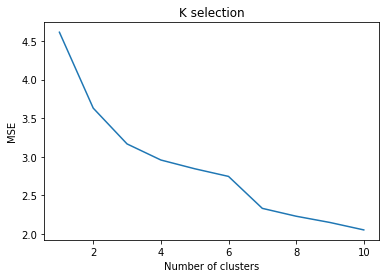

In [20]:
# Finding best k
Ks = 11
mse = np.zeros((Ks-1))
tony_grouped_clustering = tony_grouped.drop(['Neighborhood','Borough','Neighborhood Latitude','Neighborhood Longitude'], 1)
for n in range(1,Ks):
    
    # set number of clusters
    kclusters = n
    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0, init = 'random', n_init = 15).fit(tony_grouped_clustering)
    mse[n-1] = kmeans.inertia_

plt.plot(range(1,Ks),mse)
plt.xlabel("Number of clusters")
plt.ylabel("MSE")
plt.title("K selection")
plt.show()

According to the elbow method, 5 clusters are enough for finding similarities!.

In [21]:
# set number of clusters
kclusters = 5
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0, init = 'random', n_init = 15).fit(tony_grouped_clustering)
    
tony_merged = df

# add clustering labels
tony_merged['Cluster Labels'] = kmeans.labels_

tony_merged

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels
0,Manhattan,Marble Hill,40.876551,-73.910660,1
1,Manhattan,Chinatown,40.715618,-73.994279,1
2,Manhattan,Washington Heights,40.851903,-73.936900,2
...,...,...,...,...,...
75,Downtown Toronto,"First Canadian Place, Underground city",43.648429,-79.382280,1
76,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,1
77,East Toronto,Business reply mail Processing Centre969 Eastern,43.662744,-79.321558,1


### 4.2. Display clusters in maps

In [22]:
# create map
map_clusters = folium.Map(location=[centerLatitude, centerLongitude], zoom_start=7, width='100%', height='100%')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tony_merged['Latitude'], tony_merged['Longitude'], tony_merged['Neighborhood'], tony_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [23]:
# create map
map_clusters = folium.Map(location=[ny_latitude, ny_longitude], zoom_start=11, width='100%', height='100%')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tony_merged['Latitude'], tony_merged['Longitude'], tony_merged['Neighborhood'], tony_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       


minimap = MiniMap(position = 'topleft', center_fixed = (ny_latitude, ny_longitude), zoom_level_fixed = 8)
minimap.add_to(map_clusters)

minimap = MiniMap(position='bottomright',  center_fixed = (to_latitude, to_longitude), zoom_level_fixed = 8)
minimap.add_to(map_clusters)
map_clusters

In [24]:
# create map
map_clusters = folium.Map(location=[to_latitude, to_longitude], zoom_start=11, width='100%', height='100%')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tony_merged['Latitude'], tony_merged['Longitude'], tony_merged['Neighborhood'], tony_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       


minimap = MiniMap(position = 'topleft', center_fixed = (ny_latitude, ny_longitude), zoom_level_fixed = 8)
minimap.add_to(map_clusters)

minimap = MiniMap(position='bottomright',  center_fixed = (to_latitude, to_longitude), zoom_level_fixed = 8)
minimap.add_to(map_clusters)
map_clusters